#Decision Trees
We'll use the decision tree algorithm to classify data from the hepatitis and breast cancer datasets as positive and negative cases. 

The model's hyperparameter max_depth is tuned according to performance metrics over k-fold cross validation sets. 

In [ ]:
#importing dependencies 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import recall_score, precision_score, precision_recall_curve, f1_score
from google.colab import drive
drive.mount('/content/drive')

#Change your path if you need too
path_Theo = '/content/drive/My Drive/COMP 551/Assignments/Assignment 1/processed_data/'
path_David = ''
path_Jacob = '/content/drive/My Drive/Assignments/Assignment 1/processed_data/' 

path = path_Theo

Mounted at /content/drive


## 1 Decision Tree Implementation

In [ ]:
class Node:
    def __init__(self, data_indices, parent):
        self.data_indices = data_indices                    #stores the data indices which are in the region defined by this node
        self.left = None                                    #stores the left child of the node 
        self.right = None                                   #stores the right child of the node
        self.split_feature = None                           #the feature for split at this node
        self.split_value = None                             #the value of the feature for split at this node
        if parent:
            self.depth = parent.depth + 1                   #obtain the dept of the node by adding one to dept of the parent 
            self.num_classes = parent.num_classes           #copies the num classes from the parent 
            self.data = parent.data                         #copies the data from the parent
            self.labels = parent.labels                     #copies the labels from the parent
            
           # print(self.labels)
            
            #self.num_classes= self.num_classes.astype(int)
            self.labels=np.ndarray.flatten(self.labels)
            #print("hello")
            #print(self.labels[data_indices])
            #print(self.num_classes)
           
            class_prob = np.bincount(self.labels[data_indices], minlength=self.num_classes) #this is counting frequency of different labels in the region defined by this node
            self.class_prob = class_prob / np.sum(class_prob)  #stores the class probability for the node
            #note that we'll use the class probabilites of the leaf nodes for making predictions after the tree is built

In [ ]:
def greedy_test(node, cost_fn):
    #initialize the best parameter values
    best_cost = np.inf
    best_feature, best_value = None, None
    num_instances, num_features = node.data.shape
    #sort the features to get the test value candidates by taking the average of consecutive sorted feature values 
    data_sorted = np.sort(node.data[node.data_indices],axis=0)
    test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2.
    for f in range(num_features):
        #stores the data corresponding to the f-th feature
        data_f = node.data[node.data_indices, f]
        for test in test_candidates[:,f]:
            #Split the indices using the test value of f-th feature
            left_indices = node.data_indices[data_f <= test]
            right_indices = node.data_indices[data_f > test]
            #we can't have a split where a child has zero element
            #if this is true over all the test features and their test values  then the function returns the best cost as infinity
            if len(left_indices) == 0 or len(right_indices) == 0:                
                continue
            #compute the left and right cost based on the current split                                                         
            left_cost = cost_fn(node.labels[left_indices])
            right_cost = cost_fn(node.labels[right_indices])
            num_left, num_right = left_indices.shape[0], right_indices.shape[0]
            #get the combined cost using the weighted sum of left and right cost
            cost = (num_left * left_cost + num_right * right_cost)/num_instances
            #update only when a lower cost is encountered
            if cost < best_cost:
                best_cost = cost
                best_feature = f
                best_value = test
    return best_cost, best_feature, best_value

In [ ]:
#computes misclassification cost by subtracting the maximum probability of any class
def cost_misclassification(labels):
    labels = np.ndarray.flatten(labels)
    counts = np.bincount(labels) 
    class_probs = counts / np.sum(counts)
    #you could compress both the steps above by doing class_probs = np.bincount(labels) / len(labels)
    return 1 - np.max(class_probs)

#computes entropy of the labels by computing the class probabilities
def cost_entropy(labels):
    #print(labels)
    labels=np.ndarray.flatten(labels)
    class_probs = np.bincount(labels) / len(labels)
    class_probs = class_probs[class_probs > 0]              #this steps is remove 0 probabilities for removing numerical issues while computing log
    return -np.sum(class_probs * np.log(class_probs))       #expression for entropy -\sigma p(x)log[p(x)]

#computes the gini index cost
def cost_gini_index(labels):
    class_probs = np.bincount(labels) / len(labels)
    return 1 - np.sum(np.square(class_probs))               #expression for gini index 1-\sigma p(x)^2

In [ ]:
class DecisionTree:
    def __init__(self, num_classes=None, max_depth=3, cost_fn=cost_misclassification, min_leaf_instances=1):
        self.max_depth = max_depth      #maximum dept for termination 
        self.root = None                #stores the root of the decision tree 
        self.cost_fn = cost_fn          #stores the cost function of the decision tree 
        self.num_classes = num_classes  #stores the total number of classes
        self.min_leaf_instances = min_leaf_instances  #minimum number of instances in a leaf for termination
        
    def fit(self, data, labels):
      self.data = data
      self.labels = labels
      if self.num_classes is None:
        self.num_classes = np.max(labels) + 1
        #below are initialization of the root of the decision tree
      self.root = Node(np.arange(data.shape[0]), None)
      self.root.data = data
      self.root.labels = labels
      self.root.num_classes = self.num_classes
      self.root.depth = 0
    #to recursively build the rest of the tree
      self._fit_tree(self.root)
      return self
    
    def _fit_tree(self, node):
      #This gives the condition for termination of the recursion resulting in a leaf node
      if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_instances:
        return
      #greedily select the best test by minimizing the cost
      cost, split_feature, split_value = greedy_test(node, self.cost_fn)
      #if the cost returned is infinity it means that it is not possible to split the node and hence terminate
      if np.isinf(cost):
        return
      #to get a boolean array suggesting which data indices corresponding to this node are in the left of the split
      test = node.data[node.data_indices,split_feature] <= split_value
      #store the split feature and value of the node
      node.split_feature = split_feature
      node.split_value = split_value
      #define new nodes which are going to be the left and right child of the present node
      left = Node(node.data_indices[test], node)
      right = Node(node.data_indices[np.logical_not(test)], node)
      #recursive call to the _fit_tree()
      self._fit_tree(left)
      self._fit_tree(right)
      #assign the left and right child to present child
      node.left = left
      node.right = right


    def predict(self, data_test):
      class_probs = np.zeros((data_test.shape[0], self.num_classes))
      for n, x in enumerate(data_test):
        node = self.root
        #print(self.root)
        #loop along the dept of the tree looking region where the present data sample fall in based on the split feature and value
        while node.left:
          if x[node.split_feature] <= node.split_value:
            node = node.left
          else:
            node = node.right
        #the loop terminates when you reach a leaf of the tree and the class probability of that node is taken for prediction
        class_probs[n,:] = node.class_prob
        y_pred = np.argmax(class_probs,axis=-1)
      return y_pred
  

### 1.1 Performance Metrics

In [ ]:
def evaluate_acc(y_prediction, y_test):
  '''Evaluate accuracy, recall, precision, and f1 between prediction labels and actual labels'''
  acc = np.sum(y_prediction == y_test) / y_test.shape[0]
  rec = recall_score(y_test, y_prediction)
  prec = precision_score(y_test, y_prediction)
  f1 = f1_score(y_test, y_prediction)
  return acc, prec,rec,f1


def show_results(metrics, observe = None, depth_range = 20):
  '''Display the evaluation metrics for a range of K values
  @param metrics: dictionary of evaluation metrics 
  @param observe: metric to observe. dictionary key for evaluation metrics. string. if None, show all results
  @param K_range: range of K values through which to calculate performance. 
  '''
  depth_list = list(range(depth_range-1)) #list of K values 
  plt.suptitle('Peformance Metrics on Validation and Test Sets',fontsize=20, x =0.4)
  if observe == None: #display all results 
    fig = plt.figure(figsize= (20,12))
    for i,metric in enumerate(metrics):
      fig.add_subplot(3,2,i+1)
      plt.plot(depth_list, metrics[metric][1],  label=(f'{metric} on test set'))
      plt.errorbar(depth_list, np.mean(metrics[metric][0], axis=1), np.std(metrics[metric][0], axis=1),
                   label=(f'{metric} on validation set'))
      plt.legend(), plt.xlabel('Tree Depth'), plt.ylabel(metric)
    fig.tight_layout(rect=[0.03, 0.03, 0.8, 0.97])
    plt.show()
  else: #display specified result
      plt.plot(depth_list, metrics[observe][1],  label=(f'{observe} on test set'))
      plt.errorbar(depth_list, np.mean(metrics[observe][0], axis=1),
                    np.std(metrics[observe][0], axis=1), label=(f'{observe} on validation set'))
      plt.legend(), plt.xlabel('Tree Depth'), plt.ylabel(observe)
      plt.show()

###1.3 Cross Validation
Let's split the dataset into a test set and a cross validation set, train and test the model L times over L folds of the cross validation set, and then test the model over the test set. 

In [ ]:
loss = lambda y, yh: np.mean((y-yh)**2) #mean squae error loss

def split_data(dataset, test_prop = 0.2):
  y,x = dataset[:,:1].astype(int), dataset[:,1:] #separate features and labels
  sample_count = x.shape[0]  #number of total examples
  test_count = int(sample_count * 0.2) #number of test examples 
  x_train, y_train = x[test_count:], y[test_count:] #slice training set
  x_test, y_test = x[:test_count], y[:test_count] #slice test set
  return x_train, y_train, x_test, y_test 

def get_cv_index(num_train, L = 5):
  indices = list(range(num_train))
  num_val = num_train // L
  for l in range(L):
    validation_indices = list(range(l * num_val, (l+1)*num_val))
    train_indices = [x for x in indices if x not in validation_indices]  
    yield validation_indices, train_indices

def cross_validate_and_test(dataset, depth_range = 8, test_prop = 0.2, L = 5):
  depth_list = list(range(1,depth_range)) #range of K values 
  x, y, x_test, y_test = split_data(dataset, test_prop) #split dataset into train and test features and labels
  #initialize performance metrics 
  metrics = {'accuracy': [np.zeros((len(depth_list), L)), np.zeros((len(depth_list)))], 
             'recall': [np.zeros((len(depth_list), L)), np.zeros((len(depth_list)))],
             'precision': [np.zeros((len(depth_list), L)), np.zeros((len(depth_list)))],
             'f1': [np.zeros((len(depth_list), L)), np.zeros((len(depth_list)))], 
              'loss (MSE)': [np.zeros((len(depth_list), L)), np.zeros((len(depth_list)))]
             }
  #iterate through range of K values and validation sets         
  for i, d in enumerate(depth_list):
    for f, indices in enumerate(get_cv_index(x.shape[0], L)):
      (val_inds, train_inds) = indices
      x_train, x_val = x[train_inds], x[val_inds] #slice out train and validation sets
      y_train, y_val = y[train_inds], y[val_inds]
      #start of jacobs change 
      y_train, y_val = np.ndarray.flatten(y_train),np.ndarray.flatten(y_val)
      #end of jacobvs change !!!!!!
      model = DecisionTree(max_depth = d,cost_fn=cost_misclassification,num_classes=2) #create a model
      y_val_pred = model.fit(x_train, y_train).predict(x_val) #fit training data and predict on validation data
      
     
      #get evaluation metrics
      metrics['accuracy'][0][i, f] = evaluate_acc(y_val_pred, y_val.flatten())[0] 
      metrics['precision'][0][i, f] = evaluate_acc(y_val_pred, y_val.flatten())[1] 
      metrics['recall'][0][i, f] = evaluate_acc(y_val_pred, y_val.flatten())[2] 
      metrics['f1'][0][i, f] = evaluate_acc(y_val_pred, y_val.flatten())[3]
      metrics['loss (MSE)'][0][i,f] = loss(y_val_pred, y_val.flatten())  
    #predict on test_set and evaluate
    model = DecisionTree(max_depth = d,cost_fn=cost_misclassification,num_classes=2) #create a model
    y_test_pred = model.fit(x, y).predict(x_test) #fit training data and predict on validation data

    metrics['accuracy'][1][i] = evaluate_acc(y_test_pred, y_test.flatten())[0]  
    metrics['precision'][1][i] = evaluate_acc(y_test_pred, y_test.flatten())[1]  
    metrics['recall'][1][i] = evaluate_acc(y_test_pred, y_test.flatten())[2]  
    metrics['f1'][1][i] = evaluate_acc(y_test_pred, y_test.flatten())[3] 
    metrics['loss (MSE)'][1][i] = loss(y_test_pred, y_test.flatten()) 

  #best in validation set
  best_accuracy_v = np.mean(metrics['accuracy'][0], axis=1).max()
  best_depth_v = np.array(depth_list)[np.argmax(np.mean(metrics['accuracy'][0], axis=1))]
  print(f'\nHighest accuracy of {100*best_accuracy_v :.3f} on validation set is obtained for a depth of {best_depth_v}')
  #best in test set                             
  best_accuracy_t = metrics['accuracy'][1].max()
  best_depth_t = np.array(depth_list)[np.argmax(metrics['accuracy'][1])]
  print(f'\nHighest accuracy of {100*best_accuracy_t :.3f} on test set is obtained for a depth of {best_depth_t}')  
  return metrics, best_accuracy_v, best_accuracy_t, best_depth_v, best_depth_t


In [ ]:
#dataframe to contain our test results
results = pd.DataFrame({'Dataset':[], 'Highest Accuracy (Val)':[],
           'Highest Accuracy (Test)':[], 'Best Max Depth (Val)':[], 'Best Max Depth (Test)':[]})

###1.4 Plot Decision Boundaries

In [ ]:
def display_decision_boundry(data, depth ,xlabel,ylabel):
  num_classes=2
  x_train, y_train, x_test, y_test = split_data(data)
  x_allX=data[:,1:]
  x0v = np.linspace(np.min(x_allX[:,0]), np.max(x_allX[:,0]), 200)
  x1v = np.linspace(np.min(x_allX[:,1]), np.max(x_allX[:,1]), 200)
  x2v = np.linspace(np.min(x_allX[:,2]), np.max(x_allX[:,2]), 200)
  x0,x1 = np.meshgrid(x0v, x1v)
  x_all = np.vstack((x0.ravel(),x1.ravel())).T

  model = DecisionTree(max_depth=depth,num_classes=2,cost_fn=cost_misclassification)
  y_train_prob = np.zeros((y_train.shape[0], 3))
  y_train=np.ndarray.flatten(y_train)
  y_train_prob[np.arange(y_train.shape[0]), y_train] = 1

  y_prob_all = model.fit(x_train[:,:2], y_train).predict(x_all)
  y_prob_all= [[1,0,0] if x==0 else [0,1,0] for x in y_prob_all] #make the output classification into the appropriate colour
  plt.scatter(x_train[:,0], x_train[:,1], c=y_train_prob, marker='o', alpha=1)
  plt.scatter(x_all[:,0], x_all[:,1], c=y_prob_all, marker='.', alpha=.01) #we are only looking at the first two don't know if they are important 
  plt.ylabel(ylabel), plt.xlabel(xlabel), plt.title('Red: Positive, Green: Negative')
  plt.show()


## 2 Binary Classification on Breast Cancer Dataset using Nearest Neighbours
Let's test the algorithm on the breast cancer dataset first. We'll partition the dataset into a test set (20% of data) and a 5-fold cross validation set (80% of data). 

The cross validation set will be used to tune the hyperparameter max_depth to minimize the generalization error. This error will be estimated using the mean squared error. 
We'll validate and test max depths from 1 to 20 for the different datasets. 

### 2.1 Scaled Breast Cancer Dataset 



In [ ]:
cancer_scaled = pd.read_csv(path+'cancer_scaled.csv', index_col=0)
cancer_scaled = cancer_scaled.to_numpy().astype(float)
np.random.shuffle(cancer_scaled)


Highest accuracy of 94.679 on validation set is obtained for a depth of 2

Highest accuracy of 97.059 on test set is obtained for a depth of 4


<Figure size 432x288 with 0 Axes>

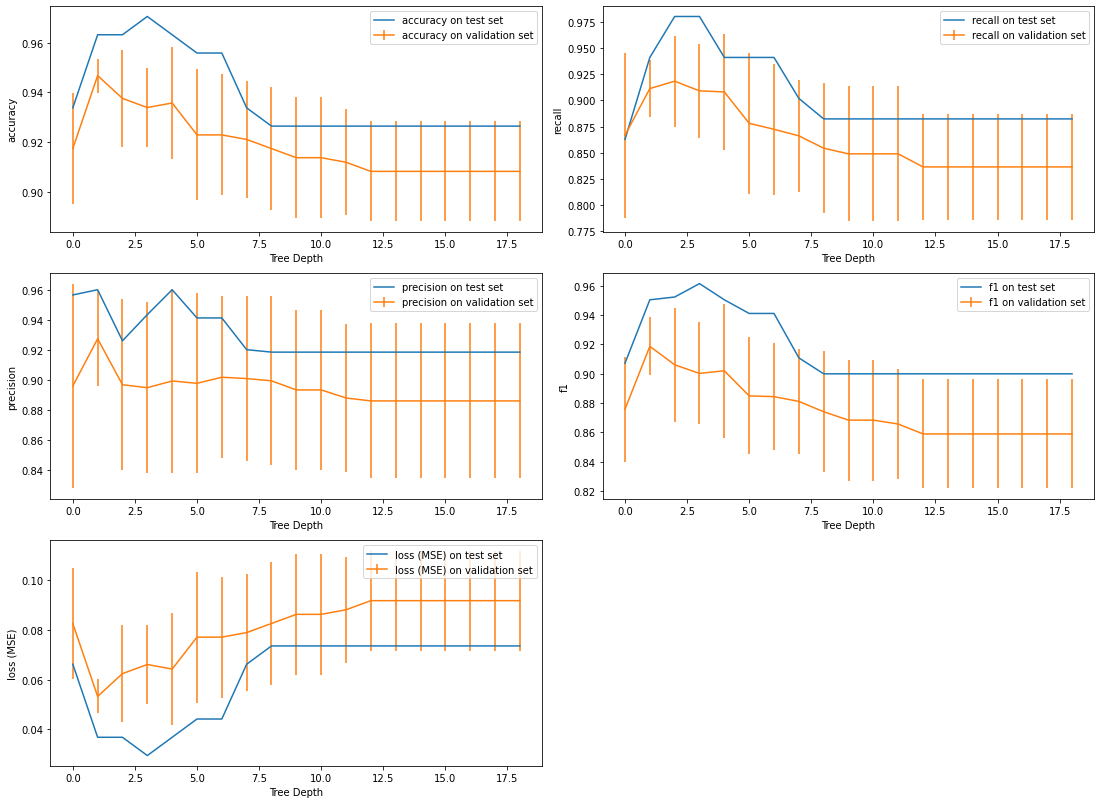

In [ ]:
metrics, best_accuracy_v, best_accuracy_t, best_depth_v, best_depth_t = cross_validate_and_test(cancer_scaled, depth_range=20)
show_results(metrics, depth_range=20)

results = results.append(pd.DataFrame({'Dataset':['Scaled Breast Cancer'],
                'Highest Accuracy (Val)':[best_accuracy_v],'Highest Accuracy (Test)':[best_accuracy_t],
                 'Best Max Depth (Val)':[best_depth_v], 'Best Max Depth (Test)':[best_depth_t]}))

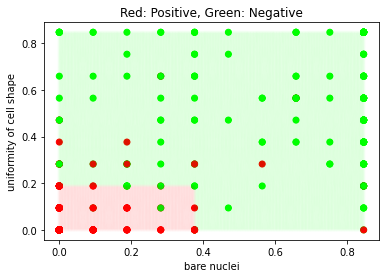

In [ ]:
display_decision_boundry(cancer_scaled,2,"bare nuclei","uniformity of cell shape")

### 2.2 Non-Scaled Breast Cancer Dataset 



In [ ]:
cancer_unscaled = pd.read_csv(path+'cancer_unscaled.csv', index_col=0)
cancer_unscaled = cancer_unscaled.to_numpy().astype(float)
np.random.shuffle(cancer_unscaled)


Highest accuracy of 95.229 on validation set is obtained for a depth of 4

Highest accuracy of 94.853 on test set is obtained for a depth of 2


<Figure size 432x288 with 0 Axes>

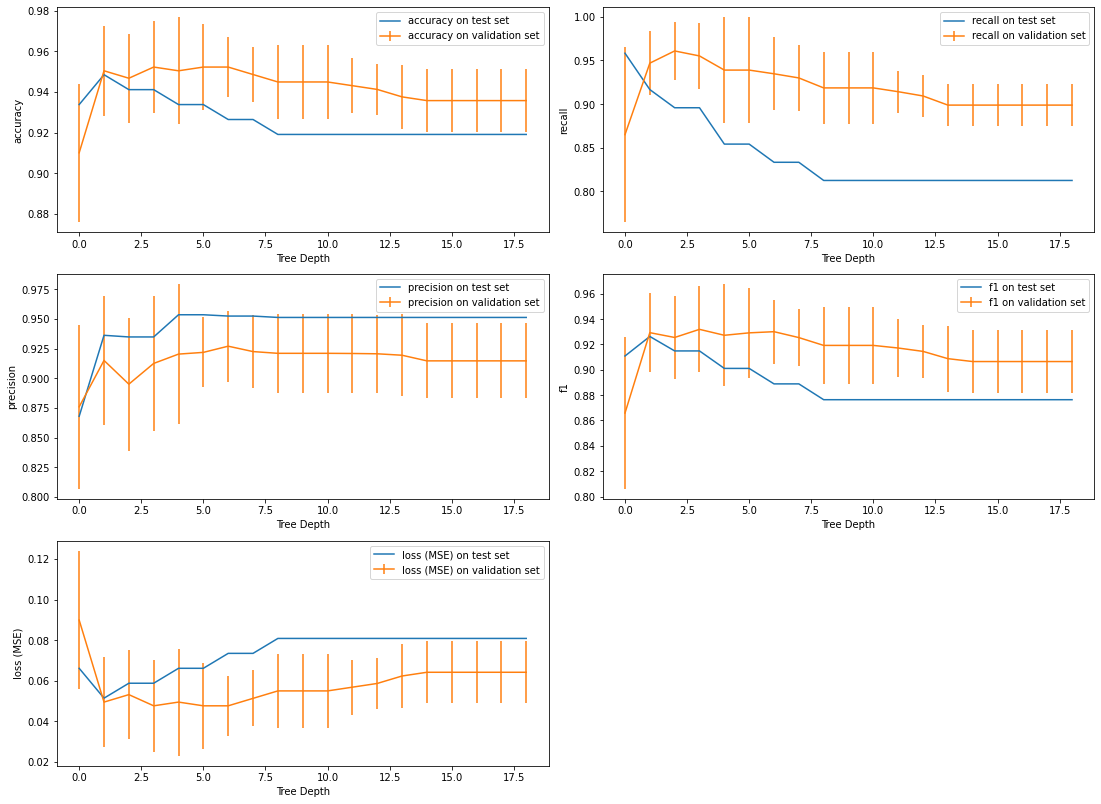

In [ ]:
metrics, best_accuracy_v, best_accuracy_t, best_depth_v, best_depth_t = cross_validate_and_test(cancer_unscaled, depth_range=20)
show_results(metrics, depth_range=20)

results = results.append(pd.DataFrame({'Dataset':['Non-Scaled Breast Cancer'],
                'Highest Accuracy (Val)':[best_accuracy_v],'Highest Accuracy (Test)':[best_accuracy_t],
                 'Best Max Depth (Val)':[best_depth_v], 'Best Max Depth (Test)':[best_depth_t]}))

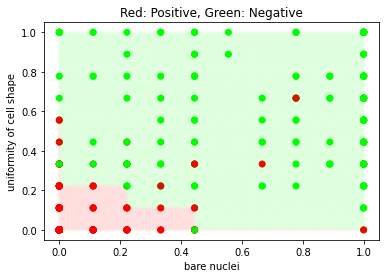

In [ ]:
display_decision_boundry(cancer_unscaled,4,"bare nuclei","uniformity of cell shape")

###2.3 Results

In [ ]:
results

,Dataset,Highest Accuracy (Val),Highest Accuracy (Test),Best Max Depth (Val),Best Max Depth (Test)
0,Scaled Breast Cancer,0.946789,0.970588,2.0,4.0
0,Non-Scaled Breast Cancer,0.952294,0.948529,4.0,2.0


## 3 Binary Classification on Hepatitis Dataset using Nearest Neighbours
Let's now test the hepatitis datasets. We'll partition the dataset into a test set (20% of data) and a 5-fold cross validation set (80% of data). 

The cross validation set will be used to tune the hyperparameter max_depth to minimize the generalization error. This error will be estimated using the mean squared error. 
We'll validate and test max depths from 1 to 20 for the different datasets. 

In [ ]:
#dataframe to contain our test results
results_h = pd.DataFrame({'Dataset':[], 'Highest Accuracy (Val)':[],
           'Highest Accuracy (Test)':[], 'Best Max Depth (Val)':[], 'Best Max Depth (Test)':[]})

### 3.1 Smaller and Scaled Hepatitis Dataset


Highest accuracy of 85.000 on validation set is obtained for a depth of 3

Highest accuracy of 87.500 on test set is obtained for a depth of 1


<Figure size 432x288 with 0 Axes>

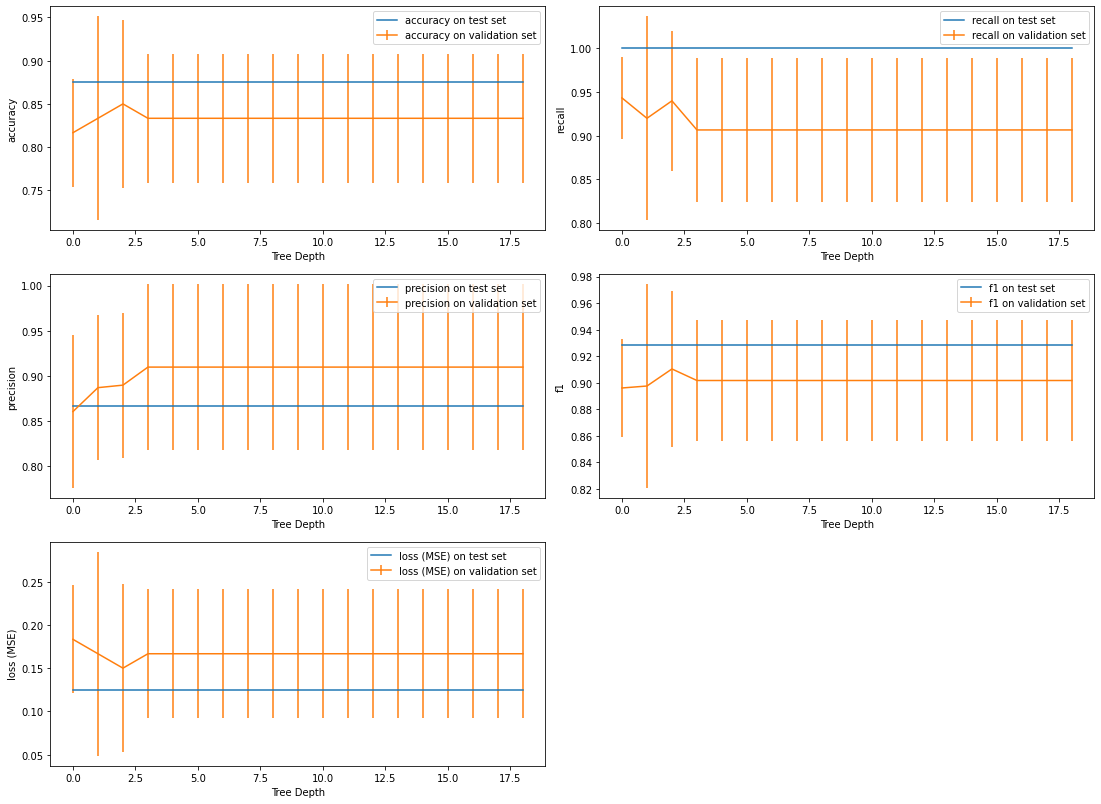

In [ ]:
hep_small_scaled = pd.read_csv(path+'hep_small_scaled.csv', index_col=0)
hep_small_scaled = hep_small_scaled.to_numpy().astype(float)
np.random.shuffle(hep_small_scaled)


metrics, best_accuracy_v, best_accuracy_t, best_depth_v, best_depth_t = cross_validate_and_test(hep_small_scaled, depth_range=20)
show_results(metrics, depth_range=20)

results_h = results_h.append(pd.DataFrame({'Dataset':['Small Scaled Hepatitis'],
                'Highest Accuracy (Val)':[best_accuracy_v],'Highest Accuracy (Test)':[best_accuracy_t],
                 'Best Max Depth (Val)':[best_depth_v], 'Best Max Depth (Test)':[best_depth_t]}))

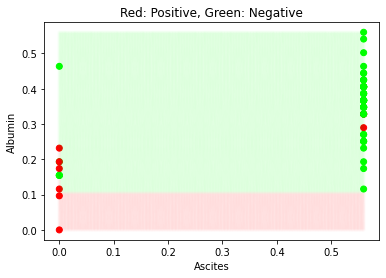

In [ ]:
display_decision_boundry(hep_small_scaled,3,"Ascites","Albumin")

### 3.2 Larger and Scaled Hepatitis Dataset


Highest accuracy of 80.000 on validation set is obtained for a depth of 5

Highest accuracy of 80.000 on test set is obtained for a depth of 2


<Figure size 432x288 with 0 Axes>

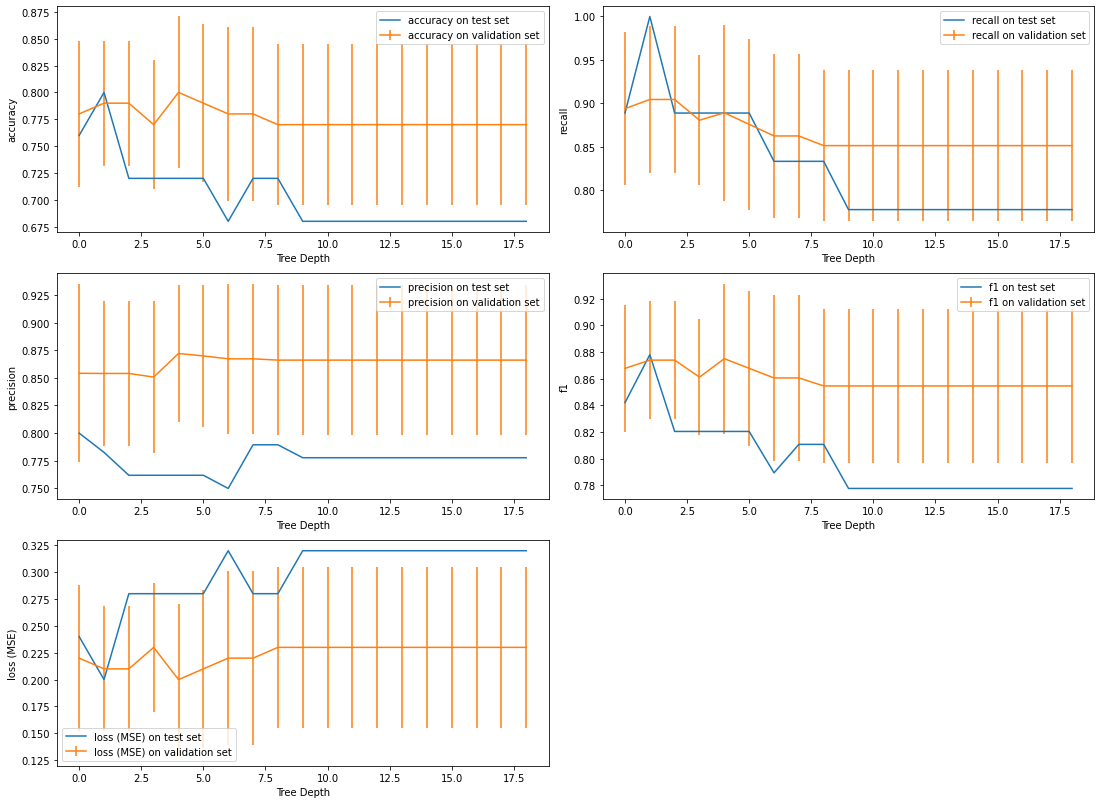

In [ ]:
hep_large_scaled = pd.read_csv(path+'hep_large_scaled.csv', index_col=0)
hep_large_scaled = hep_large_scaled.to_numpy().astype(float)
np.random.shuffle(hep_large_scaled)


metrics, best_accuracy_v, best_accuracy_t, best_depth_v, best_depth_t = cross_validate_and_test(hep_large_scaled, depth_range=20)
show_results(metrics, depth_range=20)

results_h = results_h.append(pd.DataFrame({'Dataset':['Large Scaled Hepatitis'],
                'Highest Accuracy (Val)':[best_accuracy_v],'Highest Accuracy (Test)':[best_accuracy_t],
                 'Best Max Depth (Val)':[best_depth_v], 'Best Max Depth (Test)':[best_depth_t]}))


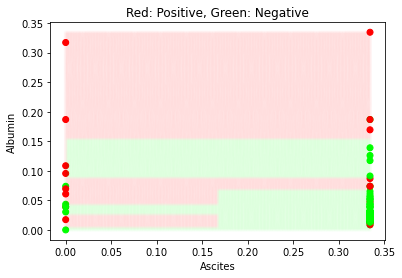

In [ ]:
display_decision_boundry(hep_large_scaled,5,"Ascites","Albumin")

### 3.3 Larger Non-Scaled Hepatitis Dataset


Highest accuracy of 84.000 on validation set is obtained for a depth of 8

Highest accuracy of 84.000 on test set is obtained for a depth of 2


<Figure size 432x288 with 0 Axes>

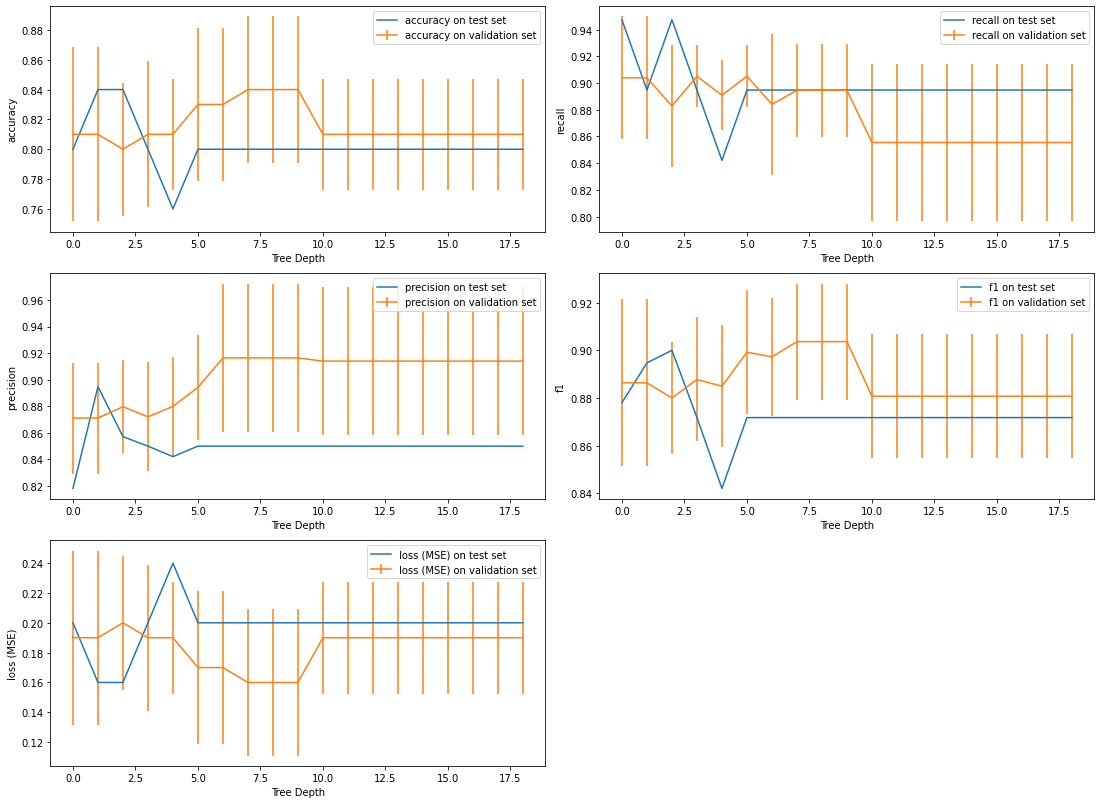

In [ ]:
hep_large_unscaled = pd.read_csv(path+'hep_large_unscaled.csv', index_col=0)
hep_large_unscaled = hep_large_unscaled.to_numpy().astype(float)
np.random.shuffle(hep_large_unscaled)


metrics, best_accuracy_v, best_accuracy_t, best_depth_v, best_depth_t = cross_validate_and_test(hep_large_unscaled, depth_range=20)
show_results(metrics, depth_range=20)

results_h = results_h.append(pd.DataFrame({'Dataset':['Large Non-Scaled Hepatitis'],
                'Highest Accuracy (Val)':[best_accuracy_v],'Highest Accuracy (Test)':[best_accuracy_t],
                 'Best Max Depth (Val)':[best_depth_v], 'Best Max Depth (Test)':[best_depth_t]}))


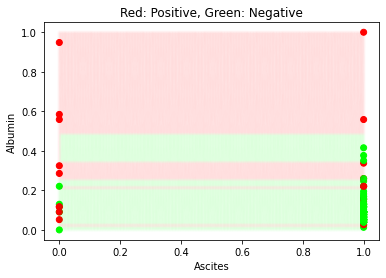

In [ ]:
display_decision_boundry(hep_large_unscaled,8,"Ascites","Albumin")

###3.4 Smaller Non-Scaled Hepatitis Dataset

In [ ]:
hep_small_unscaled = pd.read_csv(path+'hep_small_unscaled.csv', index_col=0)
hep_small_unscaled = hep_small_unscaled.to_numpy().astype(float)
np.random.shuffle(hep_small_unscaled)


metrics, best_accuracy_v, best_accuracy_t, best_depth_v, best_depth_t = cross_validate_and_test(hep_small_unscaled, depth_range=20)
#show_results(metrics, depth_range=20)

results_h = results_h.append(pd.DataFrame({'Dataset':['Small Non-Scaled Hepatitis'],
                'Highest Accuracy (Val)':[best_accuracy_v],'Highest Accuracy (Test)':[best_accuracy_t],
                 'Best Max Depth (Val)':[best_depth_v], 'Best Max Depth (Test)':[best_depth_t]}))



Highest accuracy of 81.667 on validation set is obtained for a depth of 1

Highest accuracy of 87.500 on test set is obtained for a depth of 4


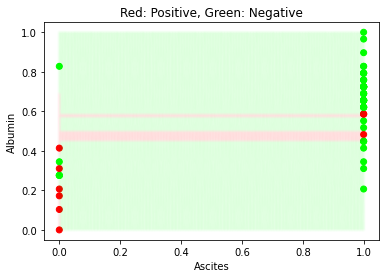

In [ ]:
display_decision_boundry(hep_small_unscaled,12,"Ascites","Albumin")

### 3.5 Larger Non-Scaled Hepatitis Dataset with Features Removed


Highest accuracy of 86.000 on validation set is obtained for a depth of 7

Highest accuracy of 88.000 on test set is obtained for a depth of 2


<Figure size 432x288 with 0 Axes>

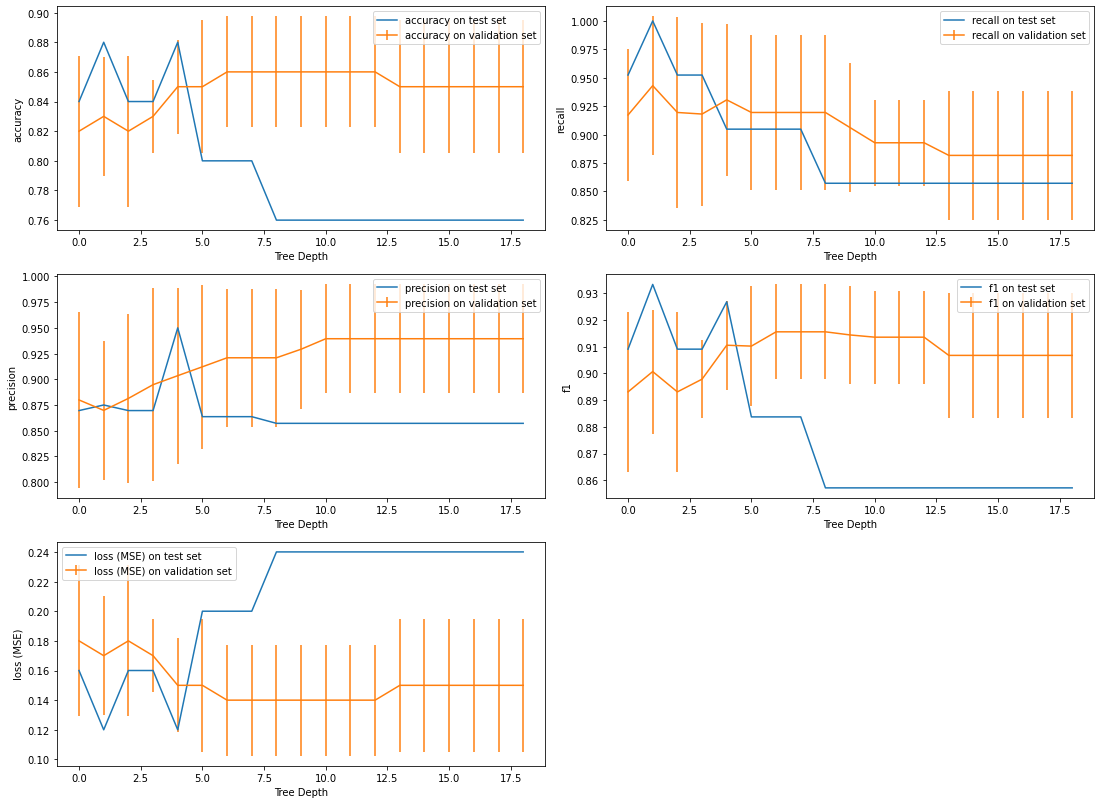

In [ ]:
hep_large_unscaled_removed = pd.read_csv(path+'hep_large_unscaled_removed.csv', index_col=0)
hep_large_unscaled_removed = hep_large_unscaled_removed.to_numpy().astype(float)
np.random.shuffle(hep_large_unscaled_removed)

metrics, best_accuracy_v, best_accuracy_t, best_depth_v, best_depth_t = cross_validate_and_test(hep_large_unscaled_removed, depth_range=20)
show_results(metrics, depth_range=20)

results_h = results_h.append(pd.DataFrame({'Dataset':['Large Non-Scaled Hepatitis with Features Removed'],
                'Highest Accuracy (Val)':[best_accuracy_v],'Highest Accuracy (Test)':[best_accuracy_t],
                 'Best Max Depth (Val)':[best_depth_v], 'Best Max Depth (Test)':[best_depth_t]}))


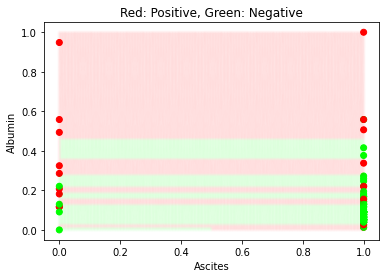

In [ ]:
display_decision_boundry(hep_large_unscaled_removed,7,"Ascites","Albumin")

### 3.6 Results

In [80]:
results_h


,Dataset,Highest Accuracy (Val),Highest Accuracy (Test),Best Max Depth (Val),Best Max Depth (Test)
0,Small Scaled Hepatitis,0.850000,0.875,3.0,1.0
1,Large Scaled Hepatitis,0.800000,0.800,5.0,2.0
2,Large Non-Scaled Hepatitis,0.840000,0.840,8.0,2.0
5,Large Non-Scaled Hepatitis with Features Removed,0.870000,0.800,1.0,2.0
8,Small Non-Scaled Hepatitis,0.816667,0.875,1.0,4.0
